In [4]:
import pymssql
import pandas as pd
import math
import numpy as np
import os

In [88]:
def conn():
    connect = pymssql.connect('10.112.195.163', 'sa', '123456', 'NJCover3D') #服务器名,账户,密码,数据库名
    if connect:
        print("连接成功!")
        return connect
    return None

connect = conn()
def query(sql):
    df0 = pd.read_sql(sql, connect)
    df = pd.DataFrame(df0)
    return df

连接成功!


连接成功!


In [69]:
sql = "SELECT * FROM tbGridFeature where inf_name in (select distinct inf_name from tbGridFeature where dis=0)"
df = query(sql)

In [83]:
def scat(df):
    df.plot.scatter(x='x',y='y')


D:\Anaconda\envs\py36\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


""


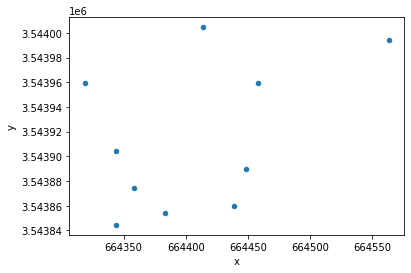

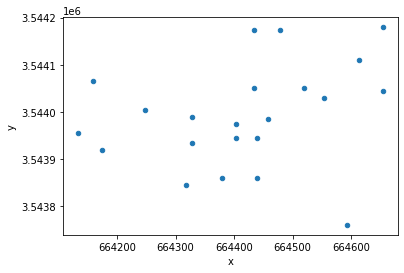

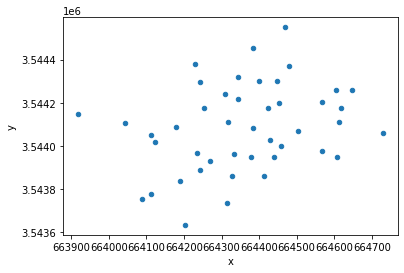

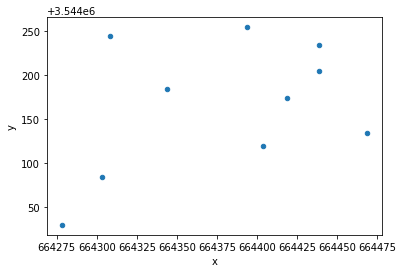

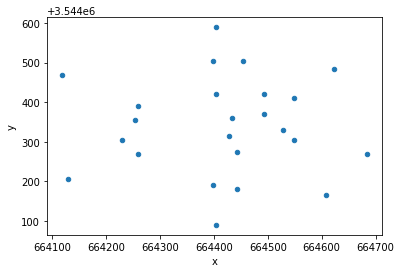

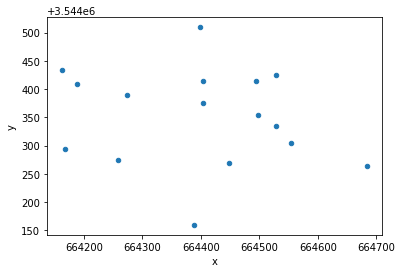

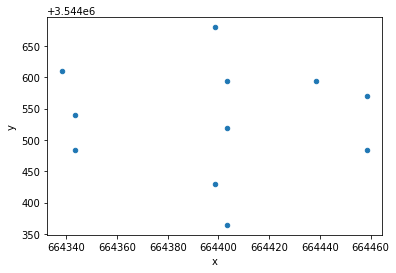

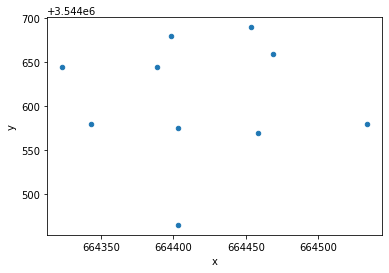

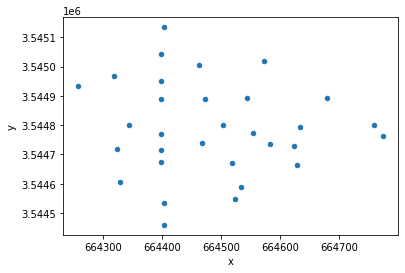

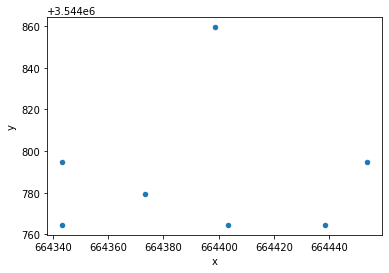

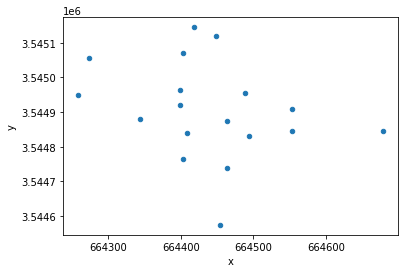

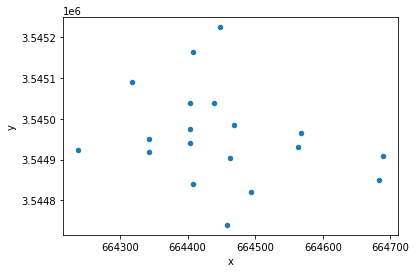

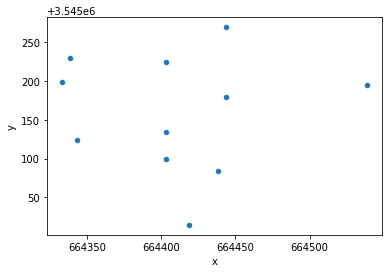

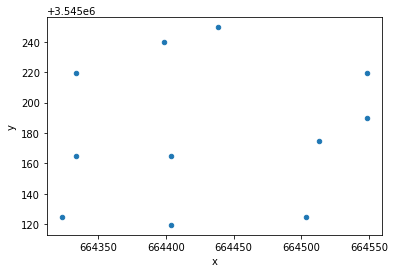

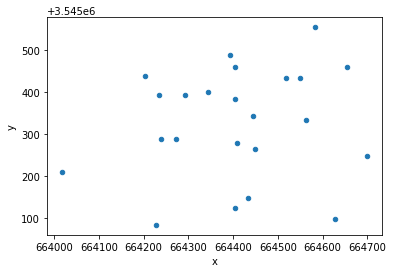

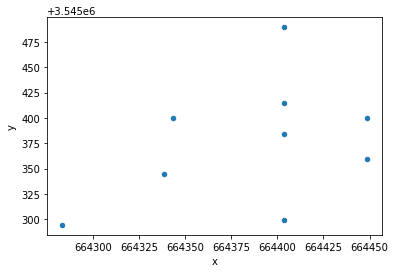

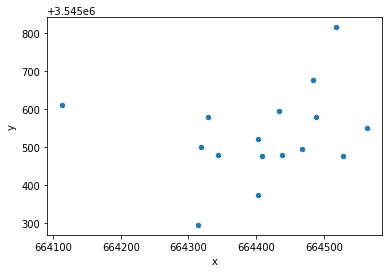

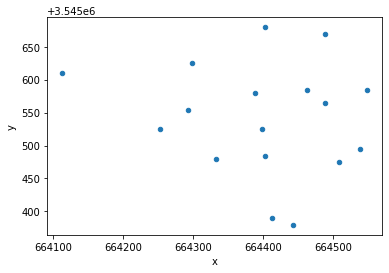

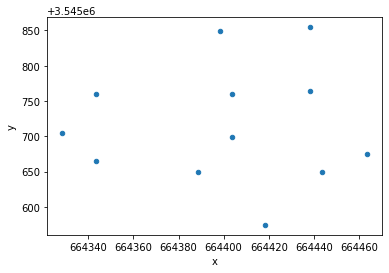

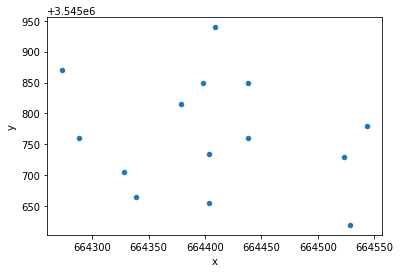

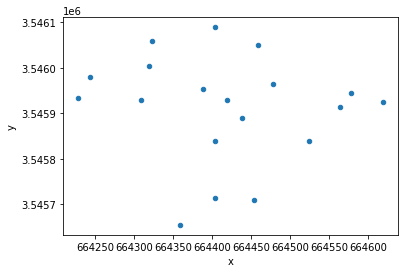

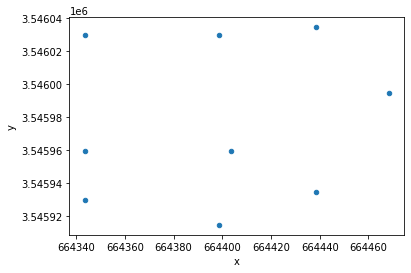

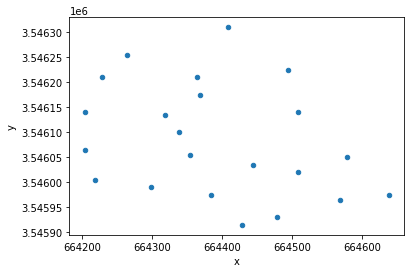

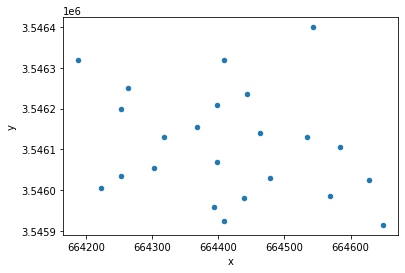

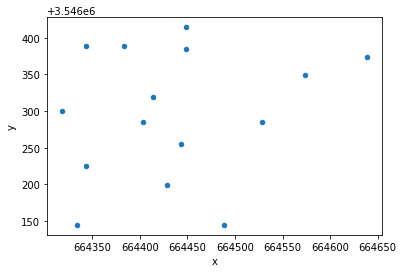

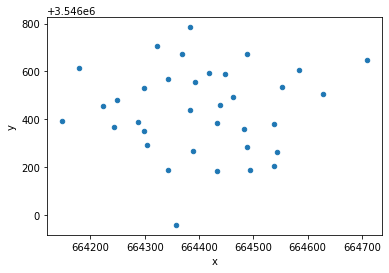

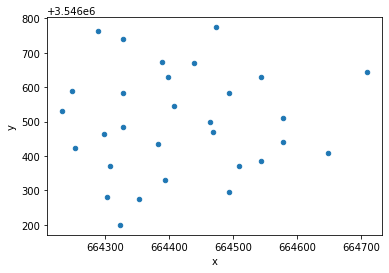

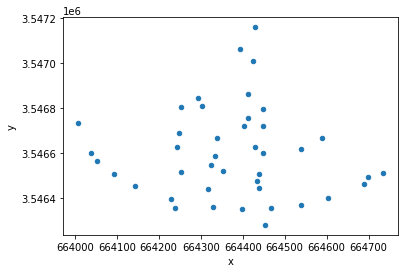

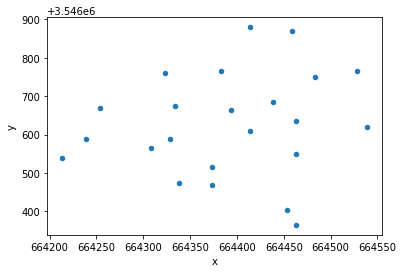

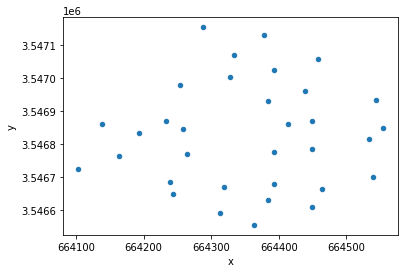

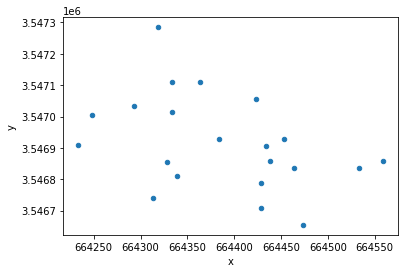

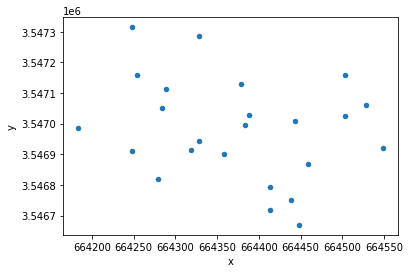

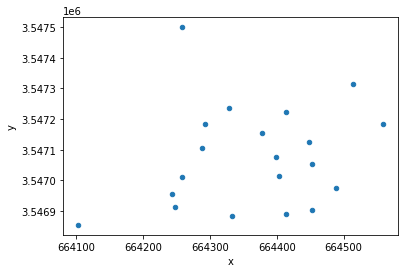

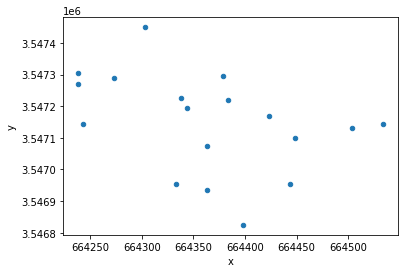

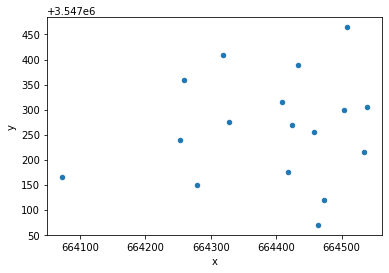

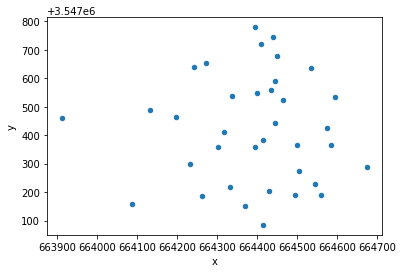

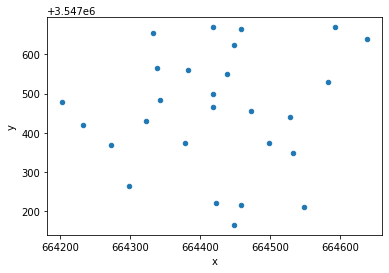

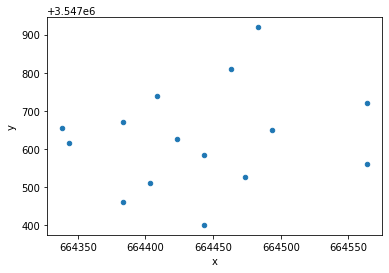

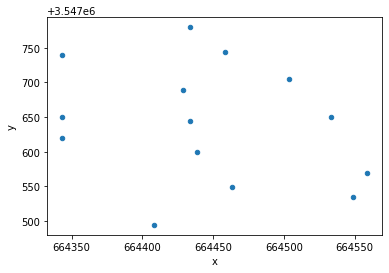

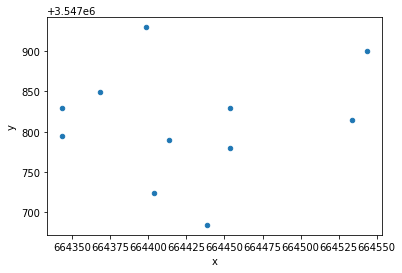

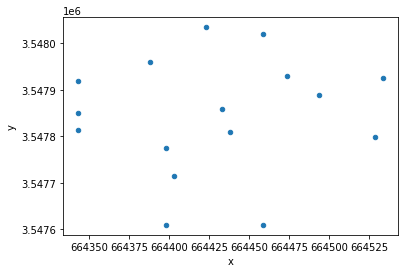

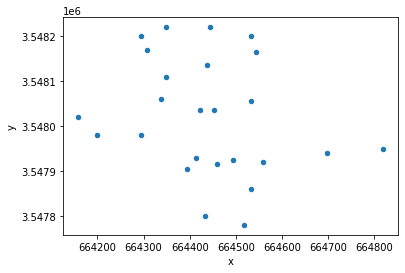

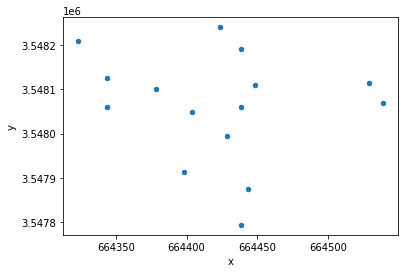

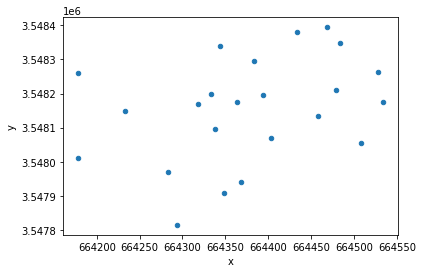

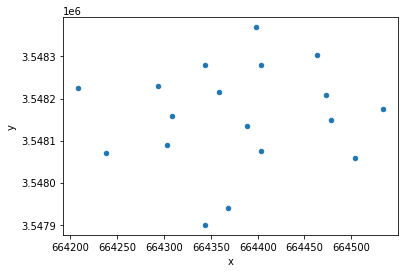

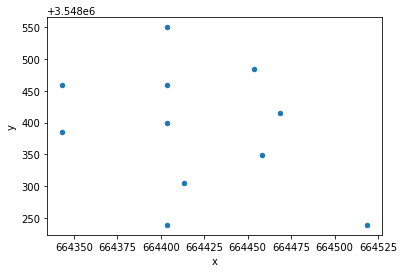

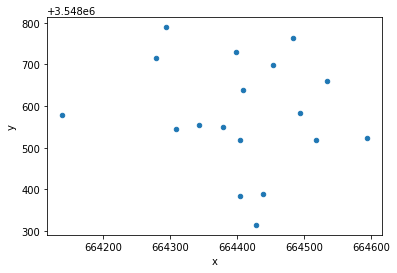

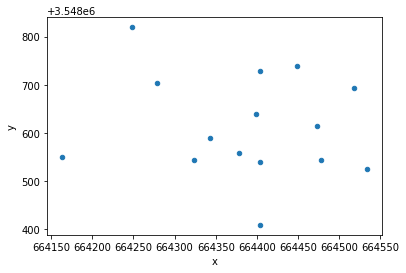

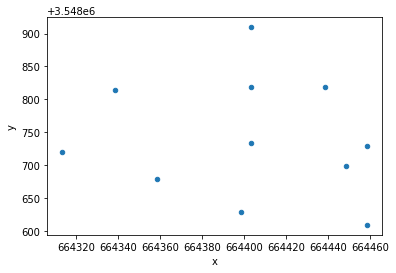

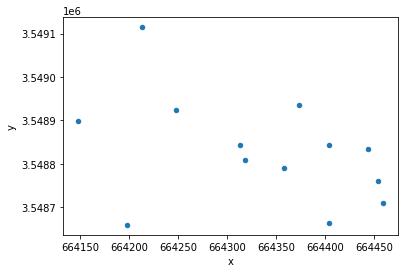

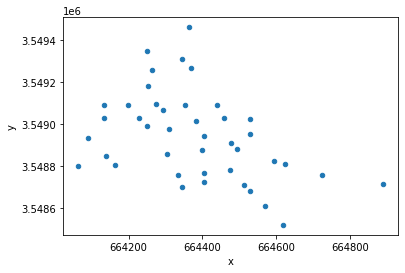

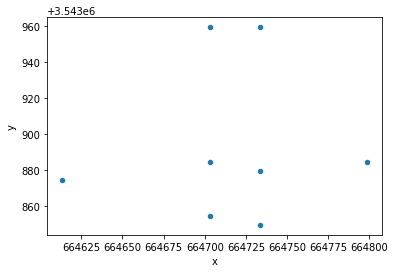

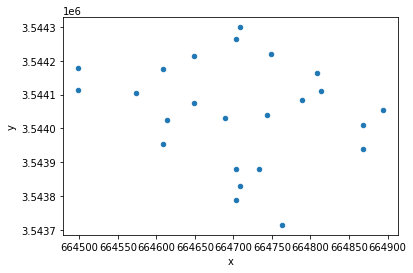

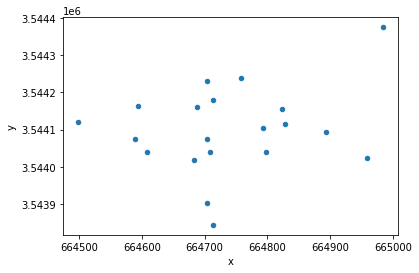

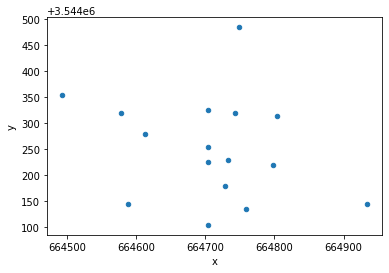

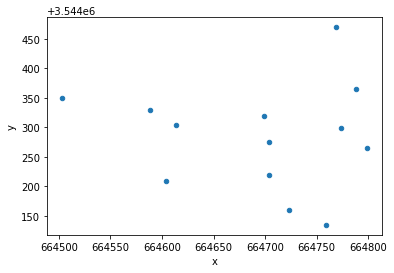

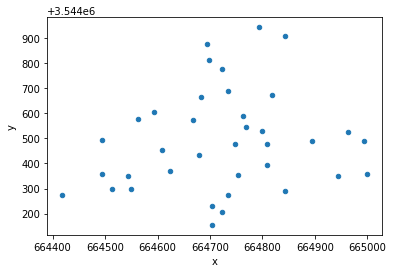

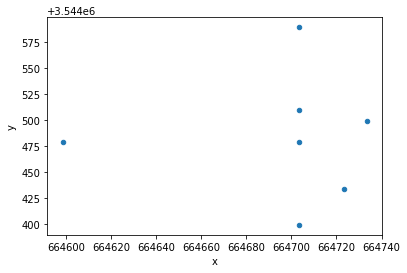

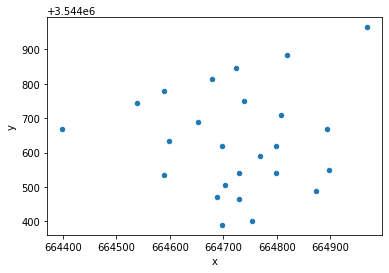

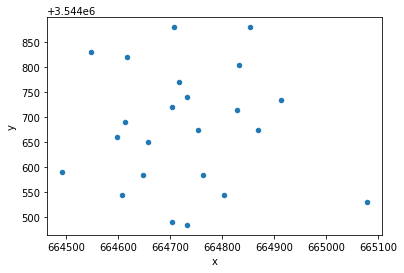

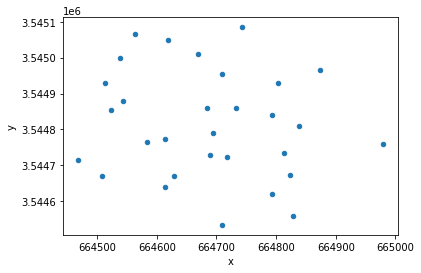

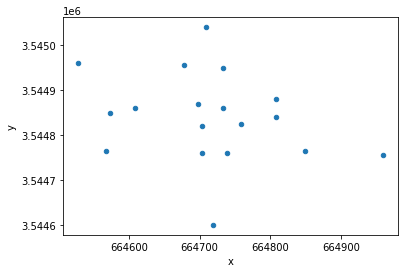

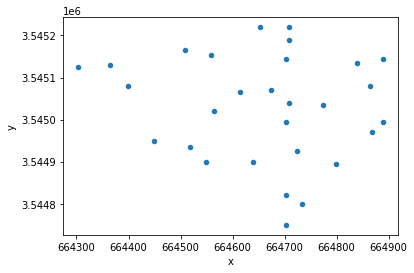

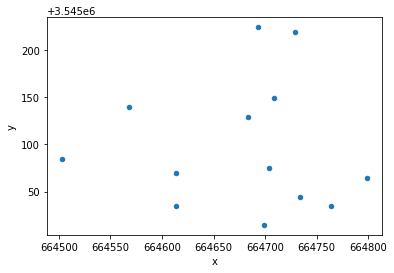

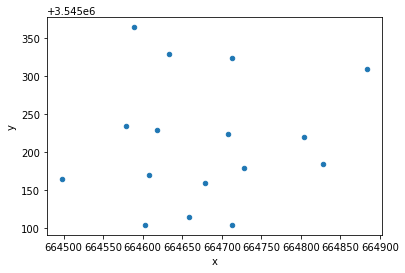

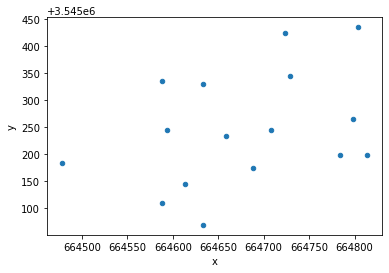

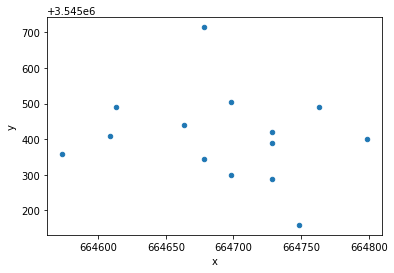

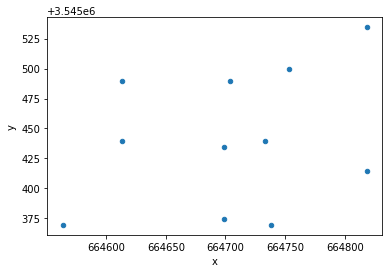

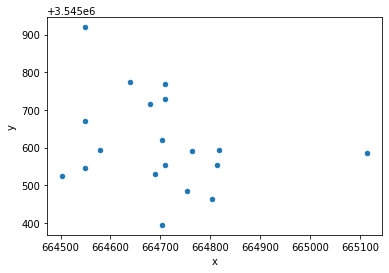

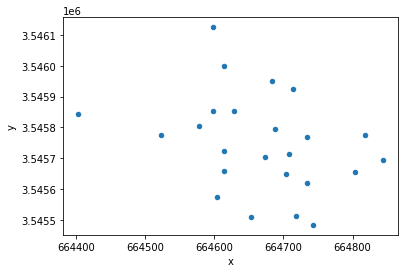

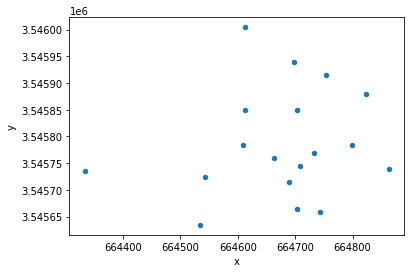

In [96]:
sql = "SELECT fromName,x,y FROM tbSelectedPoints"
ddf = query(sql)
ddf.groupby("fromName").apply(scat)

In [77]:
# dis 转换为 score，最小变最大，最大边最小，使用线性变换；特征归一化；
def featProcess(df):
    # dis 转换为 score
    thresDis = 300 #最大约束距离阈值，超出此距离的不作考虑，设为0
    gridL = 30 #栅格长度
    upLevel = 9 #起始得分放缩上限，比最高得分少1
    maxDis = math.pow(thresDis/gridL,2) #转换为栅格距离平方的最大值
    temp = upLevel-(upLevel/maxDis)*df["dis"]
    temp.loc[temp==temp.max()] = temp.max()+1
    temp.loc[temp<0] = 0
    temp = temp.round(0)
    # 删除非训练标签列
    df = df.drop(columns=['inf_name','gxid','gyid','gzid','dis'])
    # 特征归一化
    df_norm = (df - df.min()) / (df.max() - df.min())
    # 使用insert在指定位置上加入新列
    df_norm.insert(0,"score",temp)
    return df_norm

In [78]:
# 按 step*30 分层筛选，每层的衰减因子为 eta，最远的栅格只筛选前20%
def dataRefine(df,step):
#     df.hist(column='dis')
    data = pd.DataFrame()
    maxDis = df["dis"].max()
    for dL in range(0,maxDis,step):
        # refine data by step of dis
        temp = df.loc[(df["dis"] >= dL) & (df["dis"]<dL+step)]
        eta = 1-0.8*(dL/maxDis)
        k = math.floor(eta*temp.count()[0])
        data = data.append(temp.head(k))
#         print("距离:  ",dL,dL+step)
#         print("eta:  ",eta)
#         print("总数:  ",temp.count()[0])
    return data

In [105]:
# 按干扰源、高度分组
gdf = df.groupby(by=["inf_name","gzid"])
# 栅格筛选
refineData = pd.DataFrame()
refineData = gdf.apply(dataRefine,3)
# 按干扰源分组并归一化生成最终的训练数据
trainData = pd.DataFrame()

# 评价特征（gxid、gyid、gzid、dis）独立出来，写入vali文件
refineData[["inf_name","gxid","gyid","gzid","dis"]].to_csv(train_path+"vali.csv",index=False,sep=",")

# 重设分组信息
refineData = refineData.reset_index(drop=True).groupby(by="inf_name")
# 特征处理
trainData = refineData.apply(featProcess)

base_path = os.path.abspath(os.path.join(os.getcwd(), "../"))
train_path = base_path + '/data/train/'

# 保存为lightbgm需要的格式：feat+group，index=False 不要写入索引,header=None 不要写入表头
refineData["inf_name"].count().to_csv(train_path+"group.txt",index=False,header=None,sep="\n")
# feat形式  1（score） 1:0.2（特征1） 2:0.4（特征2）
feats = trainData.drop(columns="score")
# 按列遍历，然后按照lightbgm的格式进行特征转换
for i in range(0,feats.columns.size):
    feats[feats.columns[i]] = str(i)+":"+feats[feats.columns[i]].astype(str)
# 重新插入得分列
feats.insert(0,"score",trainData["score"])
feats.to_csv(train_path+"feat.txt",index=False,header=None,sep=" ")

SyntaxError: invalid syntax (<ipython-input-1-8a91e3d2a488>, line 2)